In [2]:
# Cell 1: Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn building blocks
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

import joblib


In [3]:

titanic = sns.load_dataset('titanic')
print("Shape:", titanic.shape)
titanic.head()


Shape: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [ ]:
# Quick checks
titanic.info()                  # column types, non-null counts
display(titanic.describe(include='all').T)   # summary numeric & object
print("\nMissing values per column:\n", titanic.isnull().sum().sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
sibsp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292
embarked,889,3,S,644,NaN,NaN,NaN,NaN,NaN,NaN,NaN
class,891,3,Third,491,NaN,NaN,NaN,NaN,NaN,NaN,NaN
who,891,3,man,537,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Missing values per column:
 deck           688
age            177
embarked         2
embark_town      2
sex              0
pclass           0
survived         0
fare             0
parch            0
sibsp            0
class            0
adult_male       0
who              0
alive            0
alone            0
dtype: int64


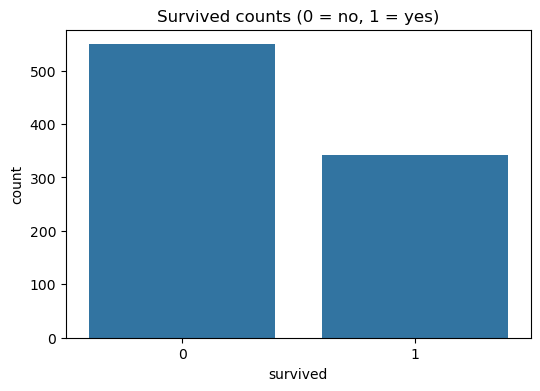

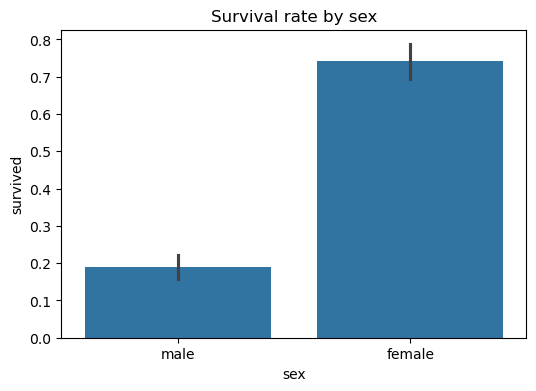

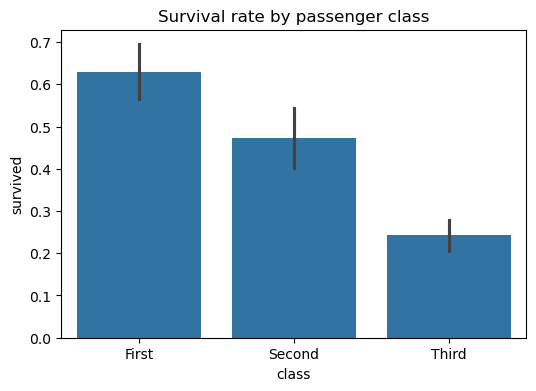

In [ ]:
#  Simple visuals to get intuition
plt.figure(figsize=(6,4))
sns.countplot(x='survived', data=titanic)
plt.title('Survived counts (0 = no, 1 = yes)')
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x='sex', y='survived', data=titanic)
plt.title('Survival rate by sex')
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x='class', y='survived', data=titanic)
plt.title('Survival rate by passenger class')
plt.show()


In [ ]:
#  Feature engineering
df = titanic.copy()

# family size
df['family_size'] = df['sibsp'].fillna(0) + df['parch'].fillna(0) + 1

# fare_per_person (avoid division by zero: family_size >=1)
df['fare_per_person'] = df['fare'] / df['family_size']

# is_alone flag (1 if alone)
df['is_alone'] = (df['family_size'] == 1).astype(int)

# keep a small preview
df[['sibsp','parch','family_size','fare','fare_per_person','is_alone']].head()


,sibsp,parch,family_size,fare,fare_per_person,is_alone
0,1,0,2,7.2500,3.62500,0
1,1,0,2,71.2833,35.64165,0
2,0,0,1,7.9250,7.92500,1
3,1,0,2,53.1000,26.55000,0
4,0,0,1,8.0500,8.05000,1


In [ ]:
#  Choose features to use for modeling
features = ['pclass', 'sex', 'age', 'fare_per_person', 'family_size', 'embarked', 'is_alone']
target = 'survived'

df_model = df[features + [target]].copy()
df_model.head()


,pclass,sex,age,fare_per_person,family_size,embarked,is_alone,survived
0,3,male,22.0,3.62500,2,S,0,0
1,1,female,38.0,35.64165,2,C,0,1
2,3,female,26.0,7.92500,1,S,1,1
3,1,female,35.0,26.55000,2,S,0,1
4,3,male,35.0,8.05000,1,S,1,0


In [ ]:
#Missing values in model columns
print(df_model.isnull().sum())


pclass               0
sex                  0
age                177
fare_per_person      0
family_size          0
embarked             2
is_alone             0
survived             0
dtype: int64


In [ ]:
# Train-test split
X = df_model.drop(columns=[target])
y = df_model[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train survived proportion:", y_train.mean(), "Test survived proportion:", y_test.mean())


Train shape: (712, 7) Test shape: (179, 7)
Train survived proportion: 0.38342696629213485 Test survived proportion: 0.3854748603351955


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define numeric and categorical columns
numeric_features = ['age', 'fare_per_person', 'family_size']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),   # fill missing numeric with median
    ('scaler', StandardScaler())
])

categorical_features = ['pclass', 'sex', 'embarked', 'is_alone']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # fill missing with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # <-- fixed
])

# Combine numeric + categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [12]:
# Logistic Regression pipeline as baseline
pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:,1]

print("Logistic Regression results:")
print(" Accuracy:", accuracy_score(y_test, y_pred_lr))
print(" ROC AUC:", roc_auc_score(y_test, y_proba_lr))
print("\nClassification report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression results:
 Accuracy: 0.7932960893854749
 ROC AUC: 0.8459815546772068

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.84       110
           1       0.76      0.68      0.72        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179



In [ ]:
#  Random Forest pipeline (stronger model)
pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)
y_proba_rf = pipe_rf.predict_proba(X_test)[:,1]

print("Random Forest results:")
print(" Accuracy:", accuracy_score(y_test, y_pred_rf))
print(" ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("\nClassification report:\n", classification_report(y_test, y_pred_rf))


Random Forest results:
 Accuracy: 0.7877094972067039
 ROC AUC: 0.8209486166007905

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83       110
           1       0.76      0.65      0.70        69

    accuracy                           0.79       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.79      0.79      0.78       179



In [14]:
# Cell 12: Optional hyperparameter tuning for RF (takes longer)
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5]
}

grid = GridSearchCV(pipe_rf, param_grid, cv=4, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)

best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:,1]
print("Test ROC AUC (best):", roc_auc_score(y_test, y_proba_best))
print(classification_report(y_test, y_pred_best))


Best params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best CV AUC: 0.8770333707330703
Test ROC AUC (best): 0.8288537549407115
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       110
           1       0.78      0.62      0.69        69

    accuracy                           0.79       179
   macro avg       0.79      0.76      0.77       179
weighted avg       0.79      0.79      0.78       179



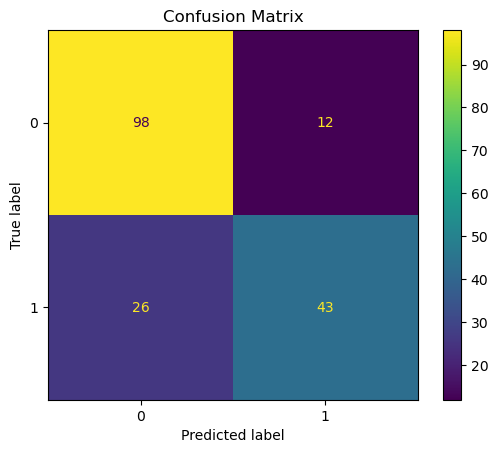

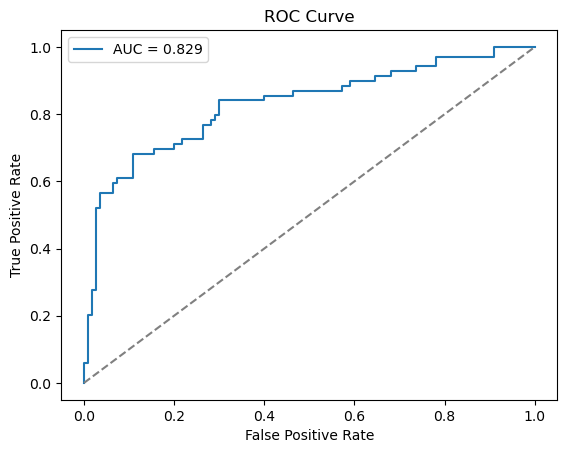

In [15]:
#  Evaluate chosen model (use best_model if grid used, else pipe_rf)
chosen = best_model if 'best_model' in globals() else pipe_rf

# Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(chosen, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()

# ROC curve
y_proba = chosen.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Top features:
 fare_per_person    0.217287
sex_female         0.193653
age                0.192020
sex_male           0.170285
pclass_3           0.061023
family_size        0.053216
pclass_1           0.032112
embarked_S         0.017397
pclass_2           0.017214
embarked_C         0.014129
is_alone_0         0.011273
is_alone_1         0.011233
embarked_Q         0.009158
dtype: float64


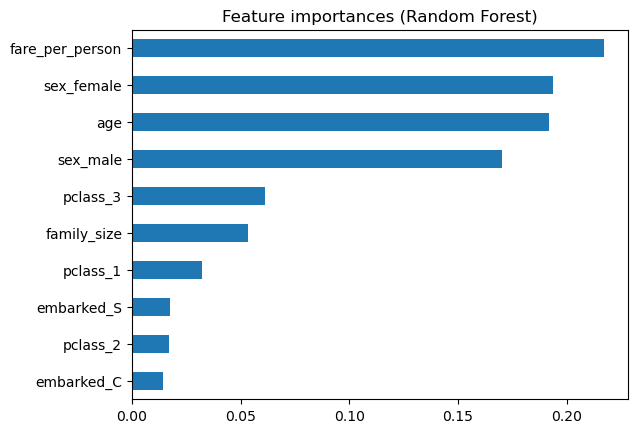

In [16]:
#  Feature importance from Random Forest (after preprocessing)


# 1) Fit preprocessor on full training data if not already (safe)
preprocessor_fit = preprocessor.fit(X_train)

# 2) Get numeric feature names (they're same as numeric_features)
num_names = numeric_features

# 3) Get categorical one-hot names from the fitted OneHotEncoder
# extract the onehot encoder used inside the ColumnTransformer
ohe = preprocessor_fit.named_transformers_['cat'].named_steps['onehot']
# build names: e.g. pclass_1 pclass_2 sex_male etc.
cat_names = []
cat_input_names = categorical_features  # ['pclass', 'sex', 'embarked', 'is_alone']
ohe_categories = ohe.categories_
for name, cats in zip(cat_input_names, ohe_categories):
    for cat in cats:
        cat_names.append(f"{name}_{cat}")

# final feature name list
feature_names = list(num_names) + cat_names

# get tree feature importances (from chosen model's classifier)
clf = chosen.named_steps['classifier']
importances = clf.feature_importances_

# pair and show top features
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("Top features:\n", fi.head(15))

# plot top 10
fi.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Feature importances (Random Forest)")
plt.show()


In [17]:
#  Save the chosen pipeline (best_model if tuned, else pipe_rf)
final_pipeline = best_model if 'best_model' in globals() else pipe_rf
joblib.dump(final_pipeline, "titanic_rf_pipeline.joblib")
print("Saved pipeline to titanic_rf_pipeline.joblib")


Saved pipeline to titanic_rf_pipeline.joblib


In [18]:
#  Load and run a quick prediction example
loaded = joblib.load("titanic_rf_pipeline.joblib")

# create a one-row example in the same raw form (columns must match X's columns)
example = pd.DataFrame([{
    'pclass': 1,
    'sex': 'female',
    'age': 34,
    'fare_per_person': 80.0,
    'family_size': 1,
    'embarked': 'S',
    'is_alone': 1
}])

pred_proba = loaded.predict_proba(example)[:,1][0]
pred = loaded.predict(example)[0]
print(f"Predicted survival probability: {pred_proba:.3f}")
print("Predicted class (1=survived):", pred)


Predicted survival probability: 1.000
Predicted class (1=survived): 1
